In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/kaggle"

#changing the working directory
%cd /content/gdrive/My Drive/Colab Notebooks/kaggle/basic_brain_tumor_classification

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/kaggle/basic_brain_tumor_classification


In [ ]:
# download dataset to google drive and unzip
!kaggle datasets download -d mhantor/mri-based-brain-tumor-images
!unzip \*.zip  && rm *.zip

100% 8.99M/8.99M [00:00<00:00, 90.6MB/s]

Archive:  mri-based-brain-tumor-images.zip
  inflating: Brain_tumor_images/Normal/Normal (1).jpg  
  inflating: Brain_tumor_images/Normal/Normal (10).jpg  
  inflating: Brain_tumor_images/Normal/Normal (100).jpg  
  inflating: Brain_tumor_images/Normal/Normal (101).jpg  
  inflating: Brain_tumor_images/Normal/Normal (102).jpg  
  inflating: Brain_tumor_images/Normal/Normal (103).jpg  
  inflating: Brain_tumor_images/Normal/Normal (104).jpg  
  inflating: Brain_tumor_images/Normal/Normal (105).jpg  
  inflating: Brain_tumor_images/Normal/Normal (106).jpg  
  inflating: Brain_tumor_images/Normal/Normal (107).jpg  
  inflating: Brain_tumor_images/Normal/Normal (108).jpg  
  inflating: Brain_tumor_images/Normal/Normal (109).jpg  
  inflating: Brain_tumor_images/Normal/Normal (11).jpg  
  inflating: Brain_tumor_images/Normal/Normal (110).jpg  
  inflating: Brain_tumor_images/Normal/Normal (111).jpg  
  inflating: Brain_tumor_images/Normal/Normal (11

In [ ]:
import tensorflow as tf

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# read images and pre-processing
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3

IMAGE_FOLDER_0 = 'Brain_tumor_images/Normal'
IMAGE_FOLDER_1 = 'Brain_tumor_images/Tumor'

image_names_0 = os.listdir(IMAGE_FOLDER_0)
image_names_1 = os.listdir(IMAGE_FOLDER_1)

images_0 = np.zeros((len(image_names_0), WIDTH, HEIGHT, NUM_CHANNELS), dtype=np.float32)
images_1 = np.zeros((len(image_names_1), WIDTH, HEIGHT, NUM_CHANNELS), dtype=np.float32)

def preprocess(image):
  image = cv2.resize(image, (WIDTH, HEIGHT))
  return (image/ 127.5 - 1).astype(np.float32)

# normal
for i, image_name in enumerate(image_names_0):
  images_0[i] = preprocess(cv2.imread(IMAGE_FOLDER_0 + os.sep + image_name))

# tumor
for i, image_name in enumerate(image_names_1):
  images_1[i] = preprocess(cv2.imread(IMAGE_FOLDER_1 + os.sep + image_name))

images = np.concatenate([images_0, images_1])
labels = np.concatenate([np.zeros((len(image_names_0), 1), dtype=np.uint8), np.ones((len(image_names_1), 1), dtype=np.uint8)])

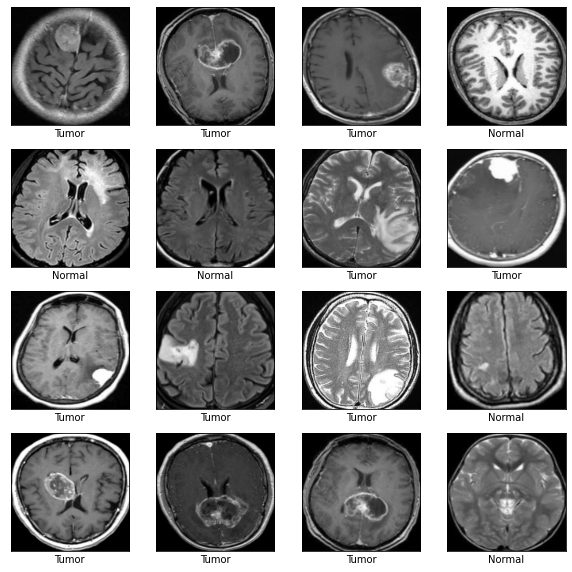

In [ ]:
plt.figure(figsize=(10,10))
display_num = 16

rand_indexs = np.random.choice(images.shape[0], display_num)
for i in range(display_num):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[rand_indexs[i]] / 2 + 0.5, cmap=plt.cm.binary)
    plt.xlabel('Tumor' if (labels[rand_indexs[i]]) else 'Normal')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 224, 224, 3)
(80, 224, 224, 3)
(320, 1)
(80, 1)


In [ ]:
# class rebalance : normal vs tumor
image_class = np.unique(labels)
class_weight = {}

for i in image_class:
	class_weight[i] = len(labels) / np.sum(labels == i)

print(class_weight)

{0: 2.3529411764705883, 1: 1.7391304347826086}


In [ ]:
# load pretrained model
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), 
                                               include_top=False, 
                                               weights='imagenet')

# freeze base model
base_model.trainable = False

print(base_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
print(model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# construct the image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                      zoom_range=0.05,
	                                                    width_shift_range=0.1,
	                                                    height_shift_range=0.1,
                                                      shear_range=0.15,
                                                      horizontal_flip=True,
                                                      fill_mode="nearest")

In [ ]:
# Define the batch size and the number of epochs to use for training
BATCH_SIZE = 32
EPOCHS = 30

history = model.fit(aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
	                  validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    class_weight=class_weight,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/30
10/10 [==============================] - 5s 404ms/step - loss: 1.9605 - accuracy: 0.4929 - val_loss: 0.6163 - val_accuracy: 0.6875
Epoch 2/30
10/10 [==============================] - 4s 387ms/step - loss: 1.2010 - accuracy: 0.6773 - val_loss: 0.6724 - val_accuracy: 0.6125
Epoch 3/30
10/10 [==============================] - 4s 385ms/step - loss: 1.0056 - accuracy: 0.7759 - val_loss: 0.4237 - val_accuracy: 0.8250
Epoch 4/30
10/10 [==============================] - 4s 384ms/step - loss: 0.7910 - accuracy: 0.8528 - val_loss: 0.4266 - val_accuracy: 0.8000
Epoch 5/30
10/10 [==============================] - 4s 386ms/step - loss: 0.8355 - accuracy: 0.8236 - val_loss: 0.4026 - val_accuracy: 0.8125
Epoch 6/30
10/10 [==============================] - 4s 384ms/step - loss: 0.6959 - accuracy: 0.8605 - val_loss: 0.3352 - val_accuracy: 0.8500
Epoch 7/30
10/10 [==============================] - 4s 385ms/step - loss: 0.6403 - accuracy: 0.8849 - val_loss: 0.3371 - val_accuracy: 0.8625
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


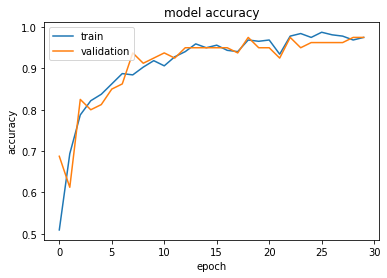

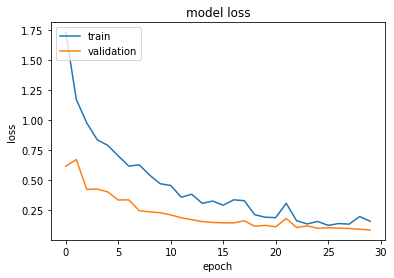

In [ ]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(x_test, BATCH_SIZE)

3/3 [==============================] - 0s 109ms/step - loss: 0.0866 - accuracy: 0.9750
Test accuracy: 0.9750000238418579


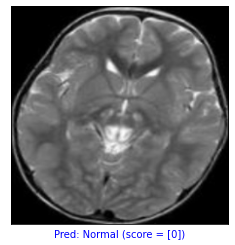

In [ ]:
def plot_image_prediction(i, predictions_value, true_label, img):
  predictions_value, true_label, img = predictions_value[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img /2 + 0.5 , cmap=plt.cm.binary)

  predicted_label = 1 if predictions_value > 0.5 else 0 

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  predicted_class = 'Tumor' if predicted_label else 'Normal'
  plt.xlabel('Pred: ' + predicted_class + ' (score = ' + str(predictions_value) + ')', color=color)

image_index = 8 #@param {type:"slider", min:0, max:100, step:1}
plot_image_prediction(image_index, y_pred, y_test, x_test)


[[29  1]
 [ 1 49]]


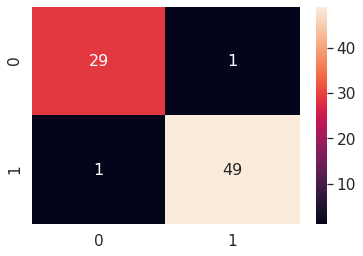

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = np.rint(y_pred).astype(int)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()